https://sejaumdatascientist.com/como-criar-um-programa-de-fidelidade-para-empresa/

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - **Alto Ticket Médio**
                + média dos preços pagos
            - **Alto LTV (life time value)**
                + quanto foi gasto na empresa
            - **Baixa Recência ou Alta Frequência**
                + tempo entre as compras - contado em dias
            - **Alto Basket Size**
                + quantidade média de produtos comprados
            - **Baixa probabilidade de Churn**
                + encerramento de contrato ou baixa da relação com a empresa
            - **Previsão alta de LTV**
            - **Alta propensão de compra**

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País / Localização
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Atributos da clusterização / Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Análise de Cohort (marcação do grupo e seu comportamento ao longo do tempo)
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ? (1 mês, 3 meses...?)
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import sklearn
import yellowbrick
import umap.umap_ as umap
from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

from IPython.core.display import HTML
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import mixture       as mx
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    
    n = pd.concat([d4, d5, d6], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis']
    return b[columns]

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv',encoding='unicode_escape')

# drop extra columns
df_raw.drop('Unnamed: 8', axis=1, inplace=True)

# <font color='red'> 1.0. Descrição dos dados </font>

In [4]:
df1 = df_raw.copy()
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename columuns

In [5]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
# storing columns names
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

## 1.2. Data dimensions

In [7]:
df1.shape

(541909, 8)

## 1.3. Data types

In [9]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 1.4. Check NA

In [6]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

### 1.5.1 Customer ID 

In [7]:
df1['customer_id'].isna().sum()/df1.shape[0]

0.249266943342886

In [8]:
# Cicle 01 - Let´s remove the NA customers and try to deal it in the next circle
df1 = df1[~df1['customer_id'].isna()]
df1.shape

(406829, 8)

In [9]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 1.5.2 Description

In [22]:
# Cicle 01 - Since all customer_id had this missing data, there is no need to treat this.

## 1.6. Change dtypes

In [10]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [11]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.7.1. Numerical Attibutes

In [13]:
describe_num(num_attributes)

,attibutes,count,mean,std,25%,50%,75%,min,max,range,skew,kurtosis
0,quantity,406829.0,12.061303,248.693370,2.00,5.00,12.00,-80995.0,80995.0,161990.0,0.182663,94317.563673
1,unit_price,406829.0,3.460471,69.315162,1.25,1.95,3.75,0.0,38970.0,38970.0,452.219019,246924.542988
2,customer_id,406829.0,15287.690570,1713.600303,13953.00,15152.00,16791.00,12346.0,18287.0,5941.0,0.029835,-1.179982


**quantity** - There is some strange values in the max and min values. Need further investigation

**unit_price** - There is some product with price equals 0 and a max values of 38.970. Need further investigation

## 1.7.2. Categorical Attibutes

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0])

invoice_no     22190
stock_code      3684
description     3896
country           37
dtype: int64

# <font color='red'> 2.0. Feature Engineering </font>

In [64]:
df2 = df1.copy()
df2.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

In [298]:
df2[df2['customer_id'] == 12347]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
14938,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2016-12-05,2.10,12347,Iceland,25.20
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2016-12-05,4.25,12347,Iceland,17.00
14940,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2016-12-05,3.25,12347,Iceland,39.00
14941,537626,22492,MINI PAINT SET VINTAGE,36,2016-12-05,0.65,12347,Iceland,23.40
14942,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,12,2016-12-05,1.25,12347,Iceland,15.00
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2016-12-05,1.25,12347,Iceland,15.00
14944,537626,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,12,2016-12-05,1.25,12347,Iceland,15.00
14945,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2016-12-05,1.25,12347,Iceland,15.00
14946,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2016-12-05,1.25,12347,Iceland,15.00
14947,537626,22805,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,12,2016-12-05,1.25,12347,Iceland,15.00


In [299]:
# gross revenue
df2['gross_revenue'] = df2['unit_price'] * df2['quantity']

df_ref_s = df2.groupby('customer_id').sum().reset_index()
df_ref_q = df2[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index()
df2_ = pd.merge(df_ref_s, df_ref_q, on='customer_id', how='left' )
#df2_ = pd.merge(df_ref_m, df_ref_q, on='customer_id', how='left' )

In [300]:
df2_.head(20)

,customer_id,quantity,unit_price,gross_revenue,invoice_no
0,12346,0,2.08,0.00,2
1,12347,2458,481.21,4310.00,182
2,12348,2341,178.71,1797.24,31
3,12349,631,605.10,1757.55,73
4,12350,197,65.30,334.40,17
5,12352,470,2211.10,1545.41,95
6,12353,20,24.30,89.00,4
7,12354,530,261.22,1079.40,58
8,12355,240,54.65,459.40,13
9,12356,1591,188.87,2811.43,59


In [301]:
df_c = df2[['customer_id', 'country']].drop_duplicates()
df2_ = pd.merge(df2_, df_c, on='customer_id', how='left' )

In [302]:
df2_.isna().sum()

customer_id      0
quantity         0
unit_price       0
gross_revenue    0
invoice_no       0
country          0
dtype: int64

# <font color='red'> 3.0. Filtragem de Variaveis </font>

In [320]:
df3 = df2_.copy()
df3.columns

Index(['customer_id', 'quantity', 'unit_price', 'gross_revenue', 'invoice_no',
       'country'],
      dtype='object')

## 3.1. Row Filtering

## 3.2. Column Filtering

In [321]:
#Cicle 1 - Invoice No its not relevant for clustering.
df3 = df3.drop(columns=['customer_id', 'country'])

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [ ]:
# Next circle

# <font color='red'> 5.0. Data Preparation </font>

In [322]:
df5 = df3.copy()
df5.head()

,quantity,unit_price,gross_revenue,invoice_no
0,0,2.08,0.00,2
1,2458,481.21,4310.00,182
2,2341,178.71,1797.24,31
3,631,605.10,1757.55,73
4,197,65.30,334.40,17


## 5.1. NORMALIZATION

In [ ]:
# No potencial normal distribution

## 5.2. RESCALLING

In [333]:
mm_qt = pp.MinMaxScaler()
df5['quantity'] = mm_qt.fit_transform(df5[['quantity']].values)

mm_up = pp.MinMaxScaler()
df5['unit_price'] = mm_up.fit_transform(df5[['unit_price']].values)

mm_gr = pp.MinMaxScaler()
df5['gross_revenue'] = mm_gr.fit_transform(df5[['gross_revenue']].values)

mm_in = pp.MinMaxScaler()
df5['invoice_no'] = mm_in.fit_transform(df5[['invoice_no']].values)

## 5.3. TRANSFORMATION

In [243]:
#le_ct = pp.LabelEncoder()
#df5['country'] = le_ct.fit_transform(df5['country'])
##
## state_holiday - One Hot Encoding
#df5 = pd.get_dummies(df5, prefix=['country'], columns=['country'])

In [334]:
df5.head()

,quantity,unit_price,gross_revenue,invoice_no
0,0.001538,0.000050,0.015109,0.000125
1,0.014014,0.011630,0.030297,0.022676
2,0.013420,0.004319,0.021442,0.003758
3,0.004741,0.014624,0.021303,0.009020
4,0.002538,0.001578,0.016288,0.002005


# <font color='red'> 6.0. Feature Selection </font>

# <font color='red'> 7.0 MACHINE LEARNING MODELLING </font>

In [335]:
X = df5.copy()

In [336]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [337]:
X.shape

(4380, 4)

## 7.1. Defining the number of Clusers - K-Means

In [338]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )
    #print('Cluster: ', k, 'Silhoutte Score: ', sil)

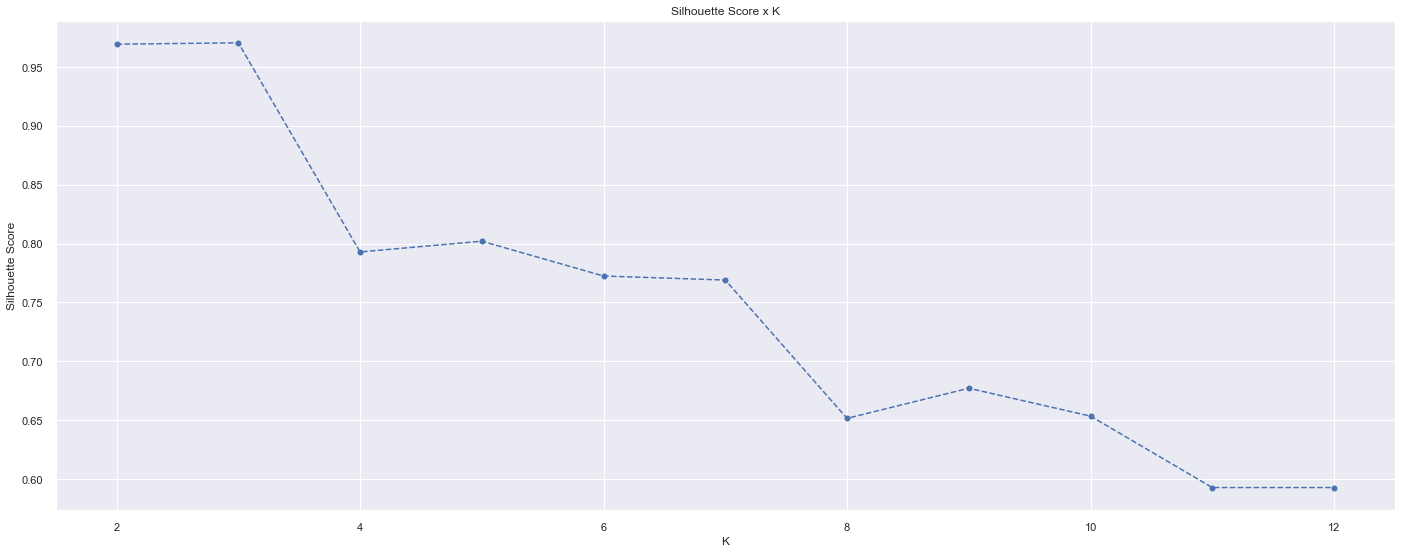

In [339]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 8.1. K-Means

In [340]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42) #max_iter iterações para achar o centróide

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [341]:
## WSS (within-cluster sum of square)
print('WSS Values: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS Values: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Values: 6.811195442594821
SS Values: 0.7856244204062145


# <font color='red'> 8.0 HYPERPARAMETER FINE TUNNING </font>

# <font color='red'> 9.0. Cluster Analysis </font>

In [345]:
df9 = df3.copy()
df9['cluster'] = labels
df9['customer_id'] = df2_['customer_id']
df9.head()

,quantity,unit_price,gross_revenue,invoice_no,cluster,customer_id
0,0,2.08,0.00,2,0,12346
1,2458,481.21,4310.00,182,0,12347
2,2341,178.71,1797.24,31,0,12348
3,631,605.10,1757.55,73,0,12349
4,197,65.30,334.40,17,0,12350


## 9.1. Visualization Inspection

In [346]:
fig = px.scatter_3d(df9, x='quantity', y='unit_price', z='gross_revenue', color='cluster')
fig.show()

## 9.2. 2d plot

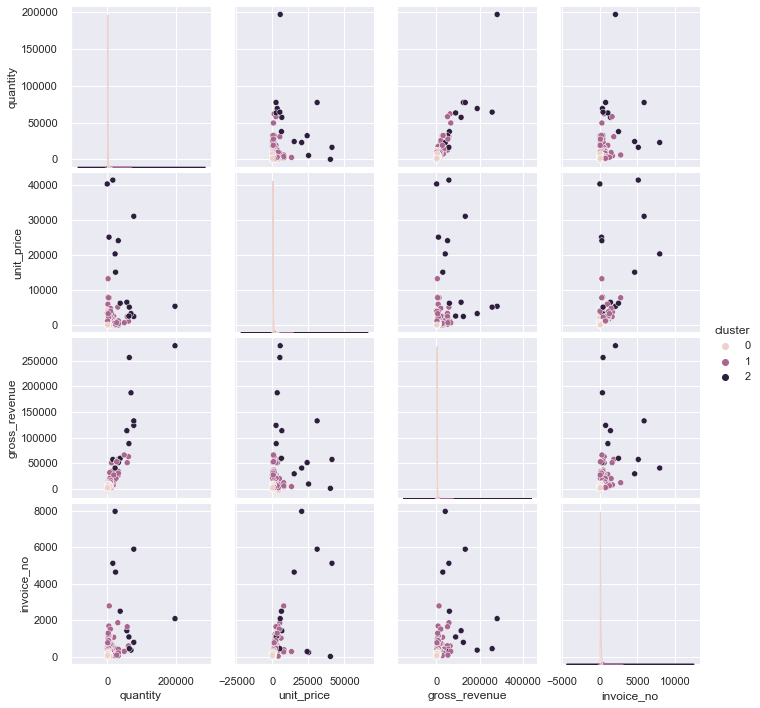

In [347]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )

## 9.1. Cluster Profile

In [353]:
df_cluster = pd.DataFrame()
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Total Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_gross_revenue['gross_revenue'] = df_avg_gross_revenue['gross_revenue'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg invoice
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

## country bt cluster
#a = df9[['country', 'cluster']].groupby(['cluster', 'country']).count().reset_index()
#prev = 0
#nv = []
#t = []
#for i in range(len(a['cluster'])):
#    actual = a['cluster'][i]
#    if actual == prev:
#        nv.append(a['country'][i])
#        #print(c)
#    else:
#        t.append([a['cluster'][i]-1, nv])
#        nv = []
#        nv.append(a['country'][i])
#    prev = actual
#t.append([a['cluster'][i], nv])
#b = pd.DataFrame(t)
#b['country'] = b[1].apply(lambda x: ', '.join(str(e) for e in x))
#b = b.rename(columns={0: 'cluster'})
#b = b.drop(columns=1)
#df_cluster = pd.merge(df_cluster, b, how='inner', on='cluster')

df_cluster = df_cluster.rename(columns={'cluster' : 'cluster', 
                                        'customer_id' : 'total_of_customers',
                                        'perc_customer' : 'perc_customer',
                                        'gross_revenue': 'avg_gross_revenue',
                                        'invoice_no' : 'avg_buying',
                                        'country' : 'country_by_cluster',
                                       })

In [354]:
df_cluster.sort_values('avg_gross_revenue', ascending=False)

,cluster,total_of_customers,perc_customer,avg_gross_revenue,avg_buying
2,2,14,0.319635,101995.21,2342.714286
1,1,299,6.826484,9189.97,444.046823
0,0,4067,92.853881,1019.94,59.549299


### Cluster 01:  ( Candidate for Insiders )
    - Number of Customers: 14 (0.31% of customers )
    - Avg Buying: 2343
    - Avg Gross Revenue: $101.995,21
        
### Cluster 02: 
    - Number of Customers: 299 (6.86% of customers )
    - Avg Buying: 444
    - Avg Gross Revenue: $9.189,97
        
### Cluster 03: 
    - Number of Customers: 4067 (92.85% of customers )
    - Avg Buying: 59
    - Avg Gross Revenue: $1.019,94

# <font color='red'> 10.0. Deploy To Production </font>